In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import math
import sys
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader

from utils.ntu_dataset import NTUDataset
import utils.augmentations as augmentations
from utils.augmentations import Normalize3D
from utils.base_dataset import BaseDataset
from model.sttformer import Model
from utils.ntu_pipeline import NTU2Feeder
from utils.Dino_utils import DinoMLP
from utils.Dino_utils import MultiCropWrapper

/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [5]:
action_classes = [
    'drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 'throw', 'sitting down',
    'standing up (from sitting position)', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap',
    'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 'reach into pocket', 'hopping (one foot jumping)',
    'jump up', 'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard',
    'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 'rub two hands together',
    'nod head/bow', 'shake head', 'wipe face', 'salute', 'put palms together', 'cross hands in front',
    'sneeze/cough', 'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)',
    'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person', 'pat on back of other person',
    'point finger at the other person', 'hugging other person', 'giving something to other person', 'touch other person\'s pocket',
    'handshaking', 'walking towards each other', 'walking apart from each other'
]

ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
        (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
        (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
        (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]

In [6]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=60)
pipeline = torchvision.transforms.Compose([augmentations.PreNormalize3D(),ntu2feeder])
augmentation = torchvision.transforms.Compose([augmentations.RandomRot(theta=0.2), augmentations.RandomScale(scale=0.2), augmentations.RandomGaussianNoise(sigma=0.005)])
strong_augmentation = torchvision.transforms.Compose([augmentations.RandomRot(theta=0.5), augmentations.RandomScale(scale=0.5), augmentations.RandomGaussianNoise(sigma=0.02)])
ntu_augmented_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_train', num_classes=60, multi_class=True, augmentation=augmentation, strong_augmentation=strong_augmentation)

In [7]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=60)
pipeline = torchvision.transforms.Compose([augmentations.PreNormalize3D(),ntu2feeder])
ntu_normal_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_val', num_classes=60, multi_class=True, augmentation=None, strong_augmentation=None)

In [8]:
tmp_aug = ntu_augmented_dataset[350]
tmp_norm = ntu_normal_dataset[350]
print(list(tmp_aug.keys()))
print(list(tmp_norm.keys()))

['frame_dir', 'label', 'keypoint', 'total_frames', 'start_index', 'samples', 'body_center']
['frame_dir', 'label', 'keypoint', 'total_frames', 'start_index', 'samples', 'body_center']


In [9]:
tmp_norm['keypoint'].shape

torch.Size([3, 60, 25, 2])

In [10]:
def get_ignore_part(mask_part):

    left_hand = [8,9,10,11,23,24]
    right_hand = [4,5,6,7,21,22]
    left_leg = [16,17,18,19]
    right_leg = [12,13,14,15]
    body = [0,1,2,3,20]
    all_joint = [left_hand, right_hand, left_leg, right_leg, body]
    part = random.sample(range(5), mask_part)
    ignore_joint = []
    for i in part:
        ignore_joint += all_joint[i]

    return ignore_joint

def reverse(data,p=0.5):

    N,C,T,V,M = data.shape
    temp = data.clone()

    if random.random() < p:
        time_range_order = [i for i in range(T)]
        time_range_reverse = list(reversed(time_range_order))
        return temp[:,:, time_range_reverse, :, :]
    else:
        return temp
    

def crop(data, temperal_padding_ratio=6):
    input_data = data.clone()
    N, C, T, V, M = input_data.shape
    #padding
    padding_len = T // temperal_padding_ratio
    frame_start = torch.randint(0, padding_len * 2 + 1,(1,))
    first_clip = torch.flip(input_data[:,:,:padding_len],dims=[2])
    second_clip = input_data
    thrid_clip = torch.flip(input_data[:,:,-padding_len:],dims=[2])
    out = torch.cat([first_clip,second_clip,thrid_clip],dim=2)
    out = out[:, :, frame_start:frame_start + T]
    return out

In [22]:
def draw_pose_3d(pose_3d, ax, colors=["#3498db", "#e74c3c"]):
    # pose_3d: [V, 3, 2], visualize 2 people
    for pair in ntu_pairs:
        for pid in [0, 1]:
            x, z, y = [np.array([pose_3d[pair[0]-1, j, pid], pose_3d[pair[1]-1, j, pid]]) for j in range(3)]
            ax.plot(x, y, z, lw=2, c=colors[pid])

In [32]:
from io import BytesIO
from PIL import Image

def record_skeleton(data):
    # choose one item to visualize
    # data: [N, C, T, V, M]
    item = data[0].permute(1, 2, 0, 3).cpu().numpy()
    # item: [T, V, C, M]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    draw_pose_3d(item[10], ax)

    for i in range(0, item.shape[0], 50):    # skip by 8
        #ax.lines = []
        pass
        # buffer = BytesIO()
        # plt.savefig(buffer, format='png')
        # img_array = np.asarray(Image.open(buffer))  # new_img就是figure的数组
        # buffer.close()
        # writer.add_image(tag + f'_{action_classes[label[0].cpu().numpy()]}', img_array, i, dataformats='HWC')


UnboundLocalError: local variable 'i' referenced before assignment

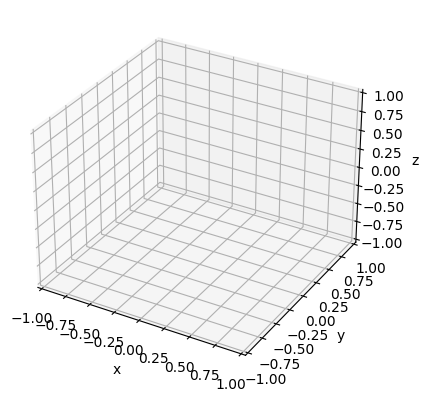

In [33]:
record_skeleton(tmp_norm['keypoint'].unsqueeze(0))

torch.Size([3, 60, 25, 2])


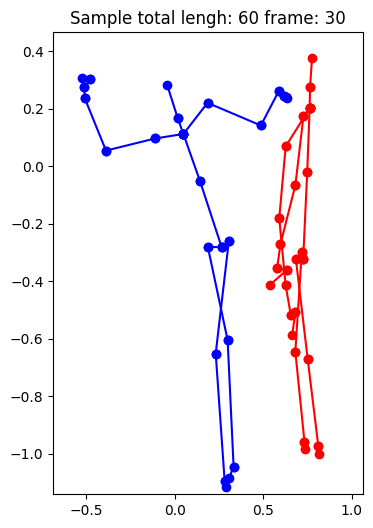

In [30]:
plot_tensor_skeleton(crop(tmp_norm['keypoint'].unsqueeze(0))[0], set_frame=30, all_subjects=True)

In [14]:
get_ignore_part(2)

[0, 1, 2, 3, 20, 4, 5, 6, 7, 21, 22]

In [22]:
print(tmp_aug['samples'][0].shape)

torch.Size([3, 60, 25, 2])


In [9]:
def plot_tensor_skeleton(tensor: torch.Tensor, set_frame: int=None, all_subjects: bool=False):
        """
        Take as input a tensor of shape (C, T, V, M)
        """
        ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
                (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
                (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
                (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
        print(tensor.shape)
        
        if set_frame is not None:
            if set_frame > tensor.shape[1]:
                raise ValueError(f"Frame value to high, total frame {tensor.shape[1]}")
            else:
                random_frame_idx = set_frame
        else:
            random_frame_idx = random.choice(range(tensor.shape[1]))

        tensor_reshaped = tensor.permute(3, 1, 2, 0)

        if all_subjects:
            x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,2]

            x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
            y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,2]

            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
                plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[:,:,:,2].numpy()), np.amax(tensor_reshaped[:,:,:,2].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
        else:
            x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint = tensor_reshaped[0][random_frame_idx][:,2]
            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[0,:,:,2].numpy()), np.amax(tensor_reshaped[0,:,:,2].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
    

torch.Size([3, 60, 25, 2])


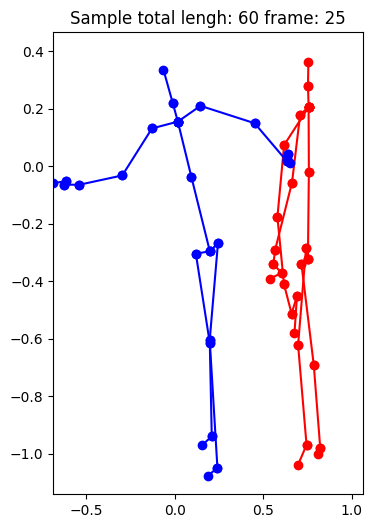

In [10]:
plot_tensor_skeleton(tmp_norm['keypoint'], set_frame=25, all_subjects=True)

torch.Size([3, 60, 25, 2])
torch.Size([3, 60, 25, 2])
torch.Size([3, 60, 25, 2])


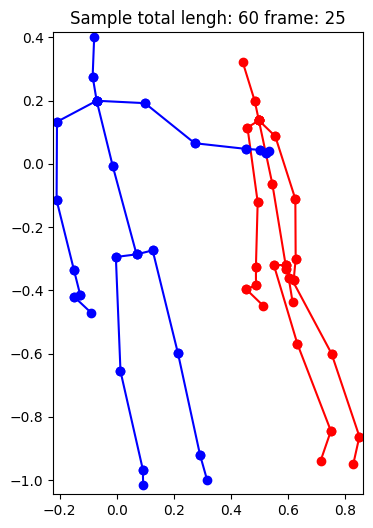

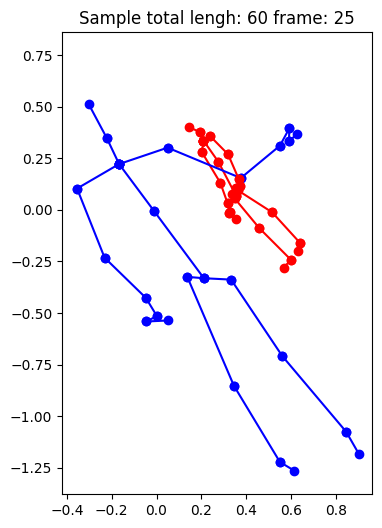

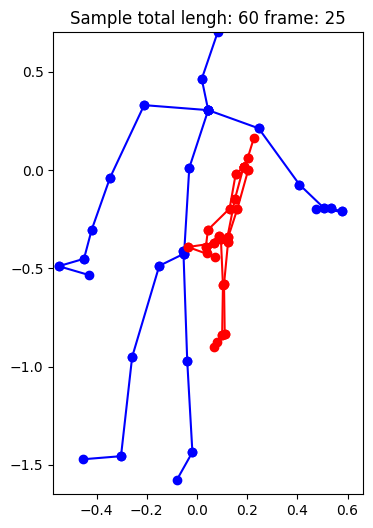

In [31]:
tmp_aug = ntu_augmented_dataset[352]
tmp_norm = ntu_normal_dataset[352]
for sample in tmp_aug['samples']:
    plot_tensor_skeleton(sample, set_frame=25, all_subjects=True)

In [10]:
### Preparing models student, teacher
output_device = 0 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

sttformer_student = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=256,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config)

sttformer_teacher = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=256,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config)

in_channels = 256
hidden_channels=1024
bottleneck_channels=256
out_channels=1024

dino_mlp = DinoMLP(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            bottleneck_channels=bottleneck_channels
)

sttformer_student = MultiCropWrapper(sttformer_student, dino_mlp)
sttformer_teacher = MultiCropWrapper(sttformer_teacher, dino_mlp)

sttformer_student = nn.DataParallel(sttformer_student, device_ids=[output_device])
sttformer_teacher = nn.DataParallel(sttformer_teacher, device_ids=[output_device])

sttformer_student, sttformer_teacher = sttformer_student.cuda(), sttformer_teacher.cuda() 

# teacher and student start with the same weights
sttformer_teacher.module.load_state_dict(sttformer_student.module.state_dict())

# there is no backpropagation through the teacher, so no need for gradients
for p in sttformer_teacher.parameters():
    p.requires_grad = False

In [11]:
# ### Preparing Projection Head
# from utils.Dino_utils import DinoMLP

# dino_mlp = DinoMLP(in_channels=256,
#                    hidden_channels=1024,
#                    bottleneck_channels=256,
#                    out_channels=1024).cuda()


In [11]:
### Preparing Loss
from utils.Dino_utils import DINOLoss

epochs = 10

dino_loss = DINOLoss(out_dim=1024,
                     ncrops=3,
                     warmup_teacher_temp=0.04,
                     teacher_temp=0.04,
                     warmup_teacher_temp_epochs=0,
                     student_temp=0.1,
                     center_momentum=0.9,
                     nepochs=epochs).cuda()


In [12]:
### Preparing Optimizer
from utils.Dino_utils import get_params_groups
from utils.Dino_utils import LARS

optimizer = 'sgd'

params_groups = get_params_groups(sttformer_student)
if optimizer == "adamw":
    optimizer = torch.optim.AdamW(params_groups, lr=0.001)  # to use with ViTs
elif optimizer == "sgd":
    optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
elif optimizer == "lars":
    optimizer = LARS(params_groups)  # to use with convnet and large batches


In [13]:
learning_rate = 0.0
weight_decay = 0.0004
optimizer = optim.SGD(params_groups,
                      lr=learning_rate,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=weight_decay)

In [11]:
batch_size_per_gpu = 128

ntu_train_dataloader = DataLoader(dataset=ntu_augmented_dataset,
                               batch_size=batch_size_per_gpu,
                               shuffle=True,
                               drop_last=True,
                               num_workers=1)

In [12]:
tmp_batch = next(iter(ntu_train_dataloader))

In [18]:
torch.argmax(tmp_batch['label'], dim=-1)

tensor([26, 33, 40, 44, 35, 20, 24, 21, 33, 47,  6,  5, 27, 17, 53, 18, 21, 19,
        16, 36, 23, 22, 39, 15, 15, 35, 48,  2, 27, 31, 47, 21, 25, 56, 44, 12,
        49, 43, 44, 40, 24, 22, 58,  1,  7, 31, 10,  3, 24,  6, 14,  1, 10, 13,
        16, 27, 14, 27,  2, 46, 57,  4, 29,  6,  5,  9, 35,  2, 34, 40, 32, 31,
        18, 31, 56, 21, 19, 38, 56, 24, 35, 12, 48, 55, 38, 51, 18, 51, 44, 37,
        19, 20, 19, 58, 13, 48, 11, 27,  3, 20, 50, 14, 55, 24, 34, 36, 45,  2,
        29, 59,  2,  1, 49,  6, 25, 27, 27, 16,  5, 16, 30,  0, 41, 54, 18,  5,
        44, 16])

In [ ]:
#dataloader_element = next(iter(ntu_train_dataloader))['samples']

In [16]:
#plot_tensor_skeleton(dataloader_element[0][10], set_frame=15, all_subjects=True)
#plot_tensor_skeleton(dataloader_element[4][10], set_frame=15, all_subjects=True)

In [15]:
### Preparing Schedulers
from utils.Dino_utils import cosine_scheduler, get_world_size

lr = 0.0
min_lr = 0.001
warmup_epochs = 2
weight_decay = 0.04
weight_decay_end = 0.4
momentum_teacher = 0.9995

lr_schedule = cosine_scheduler(
            lr * (batch_size_per_gpu * get_world_size()) / 256.,  # linear scaling rule
            min_lr,
            epochs, len(ntu_train_dataloader),
            warmup_epochs=warmup_epochs
        )
wd_schedule = cosine_scheduler(
            weight_decay,
            weight_decay_end,
            epochs, len(ntu_train_dataloader)
            )
# momentum parameter is increased to 1. during training with a cosine schedule
momentum_schedule = cosine_scheduler(momentum_teacher, 1,
                                    epochs, len(ntu_train_dataloader))
print(f"Loss, optimizer and schedulers ready.")

Loss, optimizer and schedulers ready.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


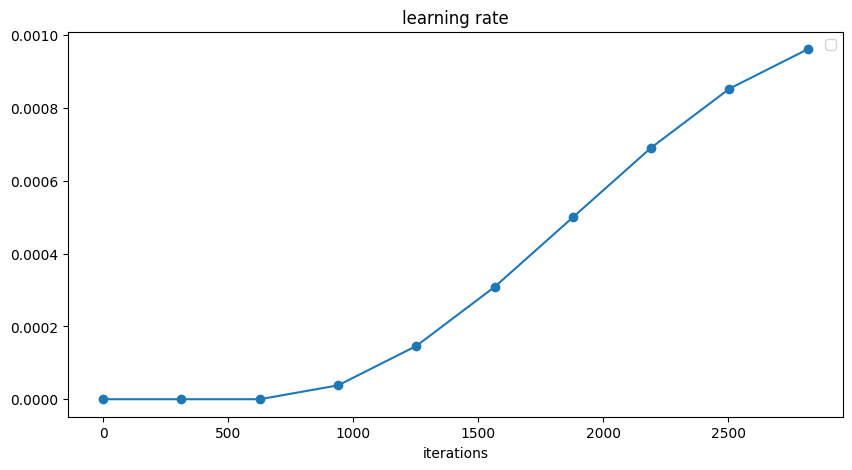

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(0,len(lr_schedule),len(ntu_train_dataloader)), lr_schedule[::len(ntu_train_dataloader)], 'o-')
plt.title("learning rate")
plt.xlabel("iterations")
plt.legend();

In [18]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts



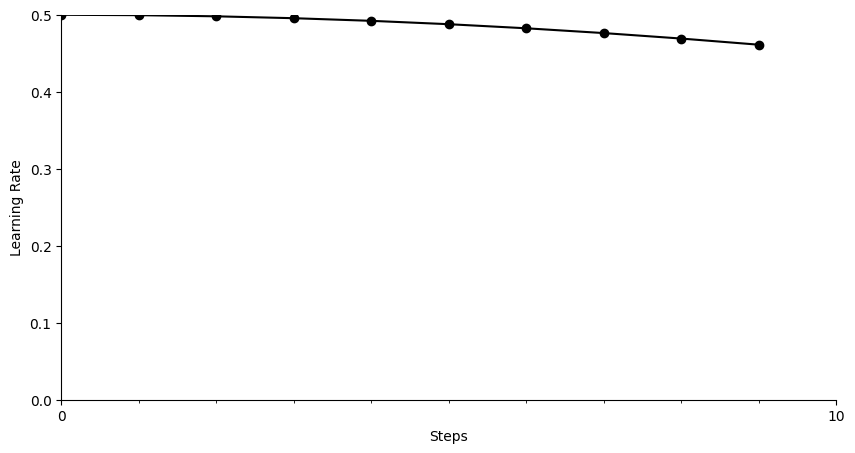

In [33]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import CosineAnnealingLR


import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

LEARNING_RATE = 0.5
EPOCHS = 10
STEPS_IN_EPOCH = 8
dataloader_len = 624 

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define your scheduler here as described above
# ...
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 50, # Maximum number of iterations.
                             eta_min = 1e-3) # Minimum learning rate.


# Get learning rates as each training step
learning_rates = []

for i in range(EPOCHS):
    for batch in range(dataloader_len):
        optimizer.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
    if (i+1) % 25 == 0:
        scheduler.base_lrs[0] = scheduler.base_lrs[0] * 0.7
    scheduler.step()

# Visualize learinig rate scheduler
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(range(EPOCHS), 
        learning_rates,
        marker='o', 
        color='black')
ax.set_xlim([0, EPOCHS])
ax.set_ylim([0, LEARNING_RATE + 0.0001])
ax.set_xlabel('Steps')
ax.set_ylabel('Learning Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.show()

In [3]:
### Training step
def train_step(student: torch.nn.Module,
               teacher: torch.nn.Module,
               dino_mlp: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               dino_loss: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               lr_schedule,
               wd_schedule,
               momentum_schedule,
               epoch,
               device=output_device):
    train_loss, lr_update, weight_decay_update = 0, 0, 0

    lr_update = optimizer.param_groups[0]["lr"]
    weight_decay_update = optimizer.param_groups[0]["weight_decay"]
    for it, batch_item in enumerate(dataloader):
        # update weight decay and learning rate according to their schedule
        it = (len(dataloader) * epoch) + it  # global training iteration
        # for i, param_group in enumerate(optimizer.param_groups):
        #         param_group["lr"] = lr_schedule[it]
        #         if i == 0:  # only the first group is regularized
        #             param_group["weight_decay"] = wd_schedule[it]

        X_views = batch_item['samples']

        
        X_views = [view.cuda(output_device) for view in X_views]

        # Forward pass
        teacher_output = teacher(X_views[:2]) # The two first views are global views

        student_output = student(X_views)
        
        loss = dino_loss(student_output, teacher_output, epoch)
        
        train_loss += loss.item()

        if not math.isfinite(loss.item()):
            print(f"Loss is {loss.item()}, stopping training")
            sys.exit(1)

        # Backward
        # student update
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher.module.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)
        
    lr_schedule.step()

    # Adjust metrics to get average loss and accuracy 
    train_loss = train_loss / len(dataloader)
    # lr_update = lr_update / len(dataloader)
    # weight_decay_update = weight_decay_update / len(dataloader)
    
    return train_loss, lr_update, weight_decay_update

NameError: name 'output_device' is not defined

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)



start_time = timer()

### Start training 

results = {"train_loss": [],
            "lr": [],
            "weight_decay": []}

# for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    train_loss, lr_update, weight_decay_update = train_step(student=sttformer_student,
                                                            teacher=sttformer_teacher,
                                                            dino_mlp=dino_mlp,
                                                            dataloader=ntu_train_dataloader,
                                                            dino_loss=dino_loss,
                                                            optimizer=optimizer,
                                                            lr_schedule=lr_schedule,
                                                            wd_schedule=wd_schedule,
                                                            momentum_schedule=momentum_schedule,
                                                            epoch=epoch,
                                                            device=output_device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | lr update: {lr_update:.4f} | Weight decay update: {weight_decay_update:.4f}")

    results["train_loss"].append(train_loss)
    results["lr"].append(lr_update)
    results["weight_decay"].append(weight_decay_update)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")
    

ERROR:tornado.general:SEND Error: Host unreachable
